# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

In [5]:
comments = []
with open("./data/loan_data.csv", "r") as file:
    for line in file:
        if line.startswith("#"):
            comments.append(line.strip())

for comment in comments:
    print(comment)

# Loan dataset based on the Kaggle Home Equity dataset
# Available at: https://www.kaggle.com/ajay1735/hmeq-data
#
# Context
# =======
# The consumer credit department of a bank wants to automate the decisionmaking
# process for approval of home equity lines of credit. To do this, they will
# follow the recommendations of the Equal Credit Opportunity Act to create an
# empirically derived and statistically sound credit scoring model. The model
# will be based on data collected from recent applicants granted credit through
# the current process of loan underwriting. The model will be built from
# predictive modeling tools, but the created model must be sufficiently
# interpretable to provide a reason for any adverse actions (rejections).
#
# Content
# =======
# The Home Equity dataset (HMEQ) contains baseline and loan performance
# information for 5,960 recent home equity loans. The target (BAD) is a binary
# variable indicating whether an applicant eventually defaulted or was
# serious

In [6]:
dataset


,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


El conjunto de datos contiene información sobre préstamos hipotecarios y el rendimiento de los mismos. El objetivo es desarrollar un modelo de puntuación crediticia que permita automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria. Para ello, contiene datos recopilados de solicitantes que obtuvieron crédito a través del proceso actual de evaluación de préstamos.

La variable objetivo que se debe predecir es "TARGET". Es una variable binaria que indica si el solicitante finalmente fue moroso o no en el pago del préstamo. Un valor de 1 significa que el cliente ha incurrido en incumplimiento, mientras que un valor de 0 significa que el préstamo ha sido pagado.

Los siguientes atributos están disponibles para realizar la predicción:

* LOAN: Monto del préstamo.
* MORTDUE: Monto adeudado en la hipoteca existente.
* VALUE: Valor de la propiedad actual.
* YOJ: Años en el trabajo actual.
* DEROG: Número de informes perjudiciales mayores.
* DELINQ: Número de líneas de crédito morosas.
* CLAGE: Antigüedad de la línea de comercio más antigua (meses).
* NINQ: Número de líneas de crédito recientes.
* CLNO: Número de líneas de crédito.
* DEBTINC: Relación deuda-ingresos.

Para la predicción, consideramos que los atributos más determinantes son aquellos relacionados con el historial crediticio y la situación financiera del solicitante. Estos incluyen si el cliente ha tenido préstamos previos ("CLNO"), si tiene préstamos sin devolver ("DELINQ"), su estabilidad laboral ("YOJ"), la cantidad del préstamo solicitado ("LOAN"), y si su deuda supera sus ingresos ("DEBTINC"). Además, factores como el número de informes perjudiciales ("DEROG"), el número de líneas de crédito morosas ("DELINQ"), el índice de deuda-ingresos ("DEBTINC"), el monto del préstamo ("LOAN"), y el valor de la propiedad ("VALUE") también pueden ser considerados en la predicción de incumplimiento del préstamo.

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [3]:
'''
Podemos leer en la documentacion, que el metodo SDG es sensible al escalado de los features.
Por eso escalemos nuestros datos de train y test.
'''
scaler= StandardScaler() # Create Scaler

X_train_scaled= scaler.fit_transform(X_train) # Scaling train data
X_test_scaled= scaler.fit_transform(X_test) # Scalinng test data


In [4]:
# Creamos nuestro modelo con los parametros por default. Solo estableciendo la semilla.
sgdc = SGDClassifier(random_state=42)
sgdc

SGDClassifier(random_state=42)

In [5]:
# Entrenamos nuestro modelo
sgdc.fit(X_train_scaled, y_train)

SGDClassifier(random_state=42)

In [6]:
sgdc.score(X_train_scaled, y_train)

0.8260283209710048

## <u>Veamos las metricas para nuestro conjunto de entrenamiento:</u>

### Veamos el classification_report:

In [7]:
# Obtenemos nuestras metricas
y_pred_train = sgdc.predict(X_train_scaled)
display(pd.DataFrame.from_dict(
    classification_report(y_train, y_pred_train,
        output_dict=True, zero_division=True)).T)

,precision,recall,f1-score,support
0,0.865616,0.935877,0.899376,1232.000000
1,0.476821,0.286853,0.358209,251.000000
accuracy,0.826028,0.826028,0.826028,0.826028
macro avg,0.671218,0.611365,0.628792,1483.000000
weighted avg,0.799812,0.826028,0.807783,1483.000000


RECALL: Es una métrica que cuenta el número de predicciones positivas correctas, entre todas las predicciones positivas que podrían haberse realizado.

PRECISION: Es una metrica que cuenta la cantidad de predicciones positivas hechas correctamente

Comparacion: A diferencia de PRECISION, que solo cuenta las predicciones positivas correctas de todas las predicciones positivas, el RECALL proporciona una indicación de las predicciones positivas mal predichas. Osea se predice no-positiva cuando si lo era.

### Veamos la matriz de confusion:

In [8]:
train_matrix= confusion_matrix(y_train, y_pred_train)
col_names = row_names = ['0','1']
better_conf_matrix_train_not_grid = pd.DataFrame(train_matrix, columns=col_names, index=row_names)
better_conf_matrix_train_not_grid
#train_matrix

,0,1
0,1153,79
1,179,72


***Vemos que nuestro modelo predijo bien 1153 personas que pidieron y devolvieron el prestamo, no lo hizo para las otras 79.
A su vez, las 179 personas que pidieron y no devolvieron el pestamo, las clasifica como si lo hubieran hecho.***

In [9]:
y_train.value_counts()

0    1232
1     251
Name: TARGET, dtype: int64

## <u>Veamos las metricas para nuestro conjunto de test:</u>

### Veamos el classification_report:

In [10]:
# Obtenemos nuestras metricas
y_pred = sgdc.predict(X_test_scaled)
display(pd.DataFrame.from_dict(
    classification_report(y_test, y_pred,
        output_dict=True, zero_division=True)).T)

,precision,recall,f1-score,support
0,0.868263,0.926518,0.896445,313.000000
1,0.378378,0.241379,0.294737,58.000000
accuracy,0.819407,0.819407,0.819407,0.819407
macro avg,0.623321,0.583948,0.595591,371.000000
weighted avg,0.791678,0.819407,0.802378,371.000000


RECALL: Es una métrica que cuenta el número de predicciones positivas correctas, entre todas las predicciones positivas que podrían haberse realizado.

PRECISION: Es una metrica que cuenta la cantidad de predicciones positivas hechas correctamente

Comparacion:
A diferencia de PRECISION, que solo cuenta las predicciones positivas correctas de todas las predicciones positivas, el RECALL proporciona una indicación de las predicciones positivas mal predichas. Osea se predice no-positiva cuando si lo era.

### Veamos la matriz de confusion:

In [11]:
matrix = confusion_matrix(y_test, y_pred)
col_names = row_names = ['0','1']
better_conf_matrix_test_not_grid = pd.DataFrame(matrix, columns=col_names, index=row_names)
better_conf_matrix_test_not_grid
#matrix

,0,1
0,290,23
1,44,14


***Al igual que en nuestras metricas de train, vemos que nuestro modelo predijo bien la mayoria de las  personas que pidieron y devolvieron el prestamo. Pero clasifica mal las personas que pidieron y no devolvieron el pestamo, las clasifica como si lo hubieran hecho.***

***Tenemos mas presencia de False-Negatives, que de True-Negatives***

In [12]:
y_test.value_counts()

0    313
1     58
Name: TARGET, dtype: int64

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [13]:
sgdc = SGDClassifier(random_state=42)

param_grid = {
    "loss" : ["hinge", "log_loss", "modified_huber", "squared_hinge"], # The loss function to be used.
    "penalty" : ["l2", "l1","elasticnet"], # The regularization term to be used
    "alpha" : [0.0001, 0.0005, 0.001], # Constant that multiplies the regularization term
    "l1_ratio" : [0.001, 0.01 ,0.1],
    "shuffle": [True, False], # Whether or not the training data should be shuffled after each epoch.
    "eta0" : [0.0001, 0.0003, 0.005, 0.01],#, 0.001, 0.01], # The initial learning rate needed for schemes other than 'optimal'
    "learning_rate" : ['optimal','constant','invscaling','adaptive'], # The learning rate schedule
#    "average": [True, False], # When set to True, computes the averaged SGD weights across all updates
}

cv = GridSearchCV(sgdc, param_grid, scoring='accuracy', cv=5)#, verbose = 4) # cv = n-fold cross-validation
cv.fit(X_train, y_train);

In [14]:
print(cv.best_estimator_) # Get details of the best model

SGDClassifier(eta0=0.0003, l1_ratio=0.1, learning_rate='adaptive',
              loss='log_loss', penalty='elasticnet', random_state=42,
              shuffle=False)


In [15]:
print(cv.best_params_)# get only the best hyperparameters values

{'alpha': 0.0001, 'eta0': 0.0003, 'l1_ratio': 0.1, 'learning_rate': 'adaptive', 'loss': 'log_loss', 'penalty': 'elasticnet', 'shuffle': False}


In [16]:
print(cv.best_score_)

0.8320980070980071


In [17]:
best_model = cv.best_estimator_ # Get best model.
best_model.fit(X_train_scaled, y_train) # Train the model.
best_model.score(X_train_scaled, y_train)

0.8739042481456507

## <u>Metricas de entrenamiento luego de grid-search:</u>

In [18]:
# Obtenemos nuestras metricas
y_train_pred = best_model.predict(X_train_scaled)
display(pd.DataFrame.from_dict(
    classification_report(y_train, y_train_pred,
        output_dict=True, zero_division=True)).T)

,precision,recall,f1-score,support
0,0.875629,0.988636,0.928708,1232.000000
1,0.847826,0.310757,0.454810,251.000000
accuracy,0.873904,0.873904,0.873904,0.873904
macro avg,0.861728,0.649697,0.691759,1483.000000
weighted avg,0.870923,0.873904,0.848500,1483.000000


In [19]:
train_matrix= confusion_matrix(y_train, y_train_pred)
col_names = row_names = ['0','1']
better_conf_matrix = pd.DataFrame(train_matrix, columns=col_names, index=row_names)
better_conf_matrix

,0,1
0,1218,14
1,173,78


***Comparemos con nuestra matriz sin el grid-search:***

In [20]:
better_conf_matrix_train_not_grid

,0,1
0,1153,79
1,179,72


### Vemos que en nuestra matriz de confusion una vez realizado el ajuste de hiperparámetros, los False-Positives disminuyen, al igual que los False-Negative.

## <u>Metricas de test luego de grid-search:</u>

In [21]:
# Obtenemos nuestras metricas
y_test_pred = best_model.predict(X_test_scaled)
display(pd.DataFrame.from_dict(
    classification_report(y_test, y_test_pred,
        output_dict=True, zero_division=True)).T)

,precision,recall,f1-score,support
0,0.882521,0.984026,0.930514,313.000000
1,0.772727,0.293103,0.425000,58.000000
accuracy,0.876011,0.876011,0.876011,0.876011
macro avg,0.827624,0.638565,0.677757,371.000000
weighted avg,0.865357,0.876011,0.851485,371.000000


In [22]:
matrix = confusion_matrix(y_test, y_test_pred)
col_names = row_names = ['0','1']
better_conf_matrix = pd.DataFrame(matrix, columns=col_names, index=row_names)
better_conf_matrix

,0,1
0,308,5
1,41,17


***Comparemos con nuestra matriz sin el grid-search:***

In [23]:
better_conf_matrix_test_not_grid

,0,1
0,290,23
1,44,14


### Al igual que en los datos de entrenamiento, en los datos de test se disminuyen los False-Positives y los False-Negative.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [24]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# metricas
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
confusion_mat = confusion_matrix(y_test, y_test_pred)

#resultados
print("Accuracy (entrenamiento):", accuracy_train)
print("Accuracy (test):", accuracy_test)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matriz de Confusión:")
print(confusion_mat)

Accuracy (entrenamiento): 1.0
Accuracy (test): 0.8867924528301887
Precision: 0.6428571428571429
Recall: 0.6206896551724138
F1 Score: 0.6315789473684211
Matriz de Confusión:
[[293  20]
 [ 22  36]]


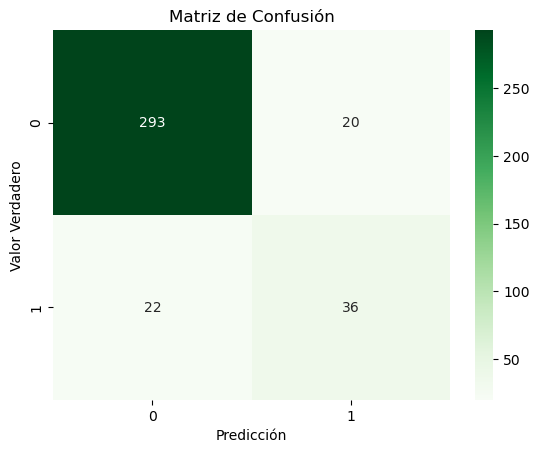

In [25]:
fig, ax = plt.subplots()
sns.heatmap(confusion_mat, annot=True, cmap="Greens", fmt="d", ax=ax)


ax.set_xlabel('Predicción')
ax.set_ylabel('Valor Verdadero')
ax.set_title('Matriz de Confusión')
plt.show()

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [26]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X, y)

results = grid_search.cv_results_

for mean_score, std_score, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print("Configuración:", params)
    print("Accuracy promedio:", mean_score)
    print("Varianza:", std_score)
    print("-----------------------------------------------------------------------")

# mejor modelo
best_clf = grid_search.best_estimator_

y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
confusion_mat = confusion_matrix(y_test, y_test_pred)

# resultados
print("Mejor configuración:", grid_search.best_params_)
print("Accuracy (entrenamiento):", accuracy_train)
print("Accuracy (test):", accuracy_test)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matriz de Confusión:")
print(confusion_mat)

Configuración: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}
Accuracy promedio: 0.841981496321119
Varianza: 0.02183386215429729
-----------------------------------------------------------------------
Configuración: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5}
Accuracy promedio: 0.8522153420266628
Varianza: 0.01571818153350472
-----------------------------------------------------------------------
Configuración: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10}
Accuracy promedio: 0.8619144751220222
Varianza: 0.02202825655743161
-----------------------------------------------------------------------
Configuración: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
Accuracy promedio: 0.8689298462883368
Varianza: 0.016685179877930764
-----------------------------------------------------------------------
Configuración: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}
Accuracy promedio: 0.8667691411087638
Varianza: 0.

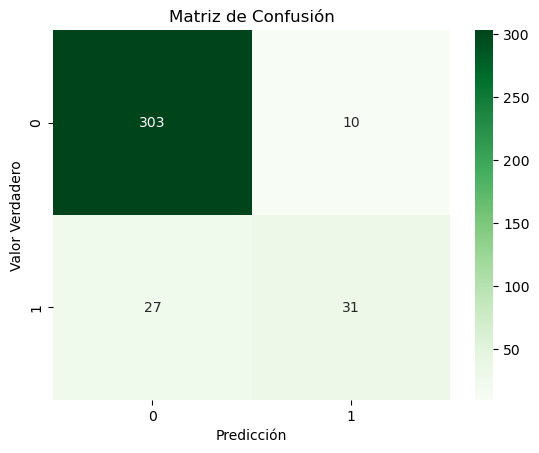

In [27]:
fig, ax = plt.subplots()
sns.heatmap(confusion_mat, annot=True, cmap="Greens", fmt="d", ax=ax)


ax.set_xlabel('Predicción')
ax.set_ylabel('Valor Verdadero')
ax.set_title('Matriz de Confusión')
plt.show()

Podemos observar que al ajustar los hiperparámetros se obtiene una mejora en el desempeño del modelo. El accuracy en el conjunto de entrenamiento disminuye ligeramente, pero esto puede indicar una reducción del sobreajuste (overfitting) del modelo. Por otro lado, el accuracy en el conjunto de evaluación aumenta, lo cual nos dice que el modelo generaliza mejor a nuevos datos de testeo.

Además, se obtiene un aumento en la precisión y en el F1 Score. Esto indica que el modelo ajustado logra clasificar correctamente más casos positivos y tiene un mejor equilibrio entre precisión y recall. En ocasiones, puede haber un trade-off entre la precisión y el recall, donde mejorar uno de ellos puede resultar en una disminución del otro. En el caso del modelo ajustado con hiperparámetros, se observa un aumento tanto en la precisión como en el recall en comparación con el modelo sin ajustar. Ento nos indica que el modelo logra clasificar correctamente más casos positivos (recall) y al mismo tiempo mantiene un buen nivel de exactitud en las predicciones positivas (precisión).